In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import classification_report, f1_score

In [2]:
adult = pd.read_csv('/Users/zaki/Downloads/adult.csv')
adult

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,22,Private,310152,Some-college,10,Never-married,Protective-serv,Not-in-family,White,Male,0,0,40,United-States,<=50K
32557,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32558,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32559,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K


# PreProcessing

preprocessing scheme:
- OneHotEncoding: relationship, race, sex
- Binary: workclass, marital.status, occupation, native.country
- Ordinal: education (already encoded, drop later)

out: fnlwgt

In [3]:
binary_encoder_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy = 'constant', fill_value = 'NC', missing_values = '?')),
    ('binary', ce.BinaryEncoder())
])

In [4]:
transformer = ColumnTransformer([
    ('one hot', OneHotEncoder(drop = 'first'), ['relationship', 'race', 'sex']),
    ('binary', binary_encoder_pipe, ['workclass', 'marital.status', 'occupation', 'native.country'])],
    remainder = 'passthrough')

*Splitting Data*

In [5]:
X = adult.drop(['fnlwgt', 'education', 'income'], axis = 1)
y = np.where(adult['income'] == '>50K', 1, 0)

In [6]:
X.shape

(32561, 12)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
X, y,
stratify = y,
random_state = 1212)

*Define Model*

In [8]:
dt = DecisionTreeClassifier(max_depth = 3)

In [9]:
pipe_tree = Pipeline([
    ('transformer', transformer),
    ('dt', dt)
])

In [10]:
adaboost = AdaBoostClassifier(
            dt,
            n_estimators = 50,
            learning_rate = 0.1,
            random_state = 1212)

pipe_ada = Pipeline([
    ('transformer', transformer),
    ('adaboost', adaboost)
])

In [11]:
gradboost = GradientBoostingClassifier(
            n_estimators = 50,
            learning_rate = 0.1,
            max_depth = 3,
            random_state = 1212)

pipe_grad = Pipeline([
    ('transformer', transformer),
    ('gradboost', gradboost)
])

In [12]:
XGBOOST = XGBClassifier(
            n_estimators = 50,
            learning_rate = 0.1,
            max_depth = 3,
            random_state = 1212)

pipe_XGB = Pipeline([
    ('transformer', transformer),
    ('XGBOOST', XGBOOST)
])

*Model Evaluation* - **Cross Validation**

In [13]:
def model_evaluation(model, metric):
    skfold = StratifiedKFold(n_splits = 5)
    model_cv = cross_val_score(model, X_train, y_train, cv = skfold, scoring = metric)
    return model_cv

In [14]:
pipe_tree_cv = model_evaluation(pipe_tree, 'f1')

In [15]:
pipe_ada_cv = model_evaluation(pipe_ada, 'f1')

In [16]:
pipe_grad_cv = model_evaluation(pipe_grad, 'f1')

In [17]:
pipe_XGB_cv = model_evaluation(pipe_XGB, 'f1')

[00:32:48] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:32:50] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:32:53] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:32:55] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

In [18]:
tree = pipe_tree_cv.mean()
ada = pipe_ada_cv.mean()
grad = pipe_grad_cv.mean()
XGB = pipe_XGB_cv.mean()

In [19]:
score_list = [tree, ada, grad, XGB]
method_name = ['Decision Tree Classifier CV Score', 'Ada Boost Classifier CV Score',
              'Gradient Boost Classifier CV Score', 'XGB Classifier CV Score']
cv_summary = pd.DataFrame({
    'method': method_name,
    'score': score_list
})
cv_summary

,method,score
0,Decision Tree Classifier CV Score,0.601256
1,Ada Boost Classifier CV Score,0.661627
2,Gradient Boost Classifier CV Score,0.651965
3,XGB Classifier CV Score,0.636003


*Fitting Data*

In [20]:
pipe_tree.fit(X_train, y_train)
y_pred_tree = pipe_tree.predict(X_test)
print(classification_report(y_test, y_pred_tree))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      6181
           1       0.69      0.54      0.60      1960

    accuracy                           0.83      8141
   macro avg       0.77      0.73      0.75      8141
weighted avg       0.82      0.83      0.82      8141



In [21]:
pipe_ada.fit(X_train, y_train)
y_pred_ada = pipe_ada.predict(X_test)
print(classification_report(y_test, y_pred_ada))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      6181
           1       0.80      0.57      0.67      1960

    accuracy                           0.86      8141
   macro avg       0.84      0.76      0.79      8141
weighted avg       0.86      0.86      0.85      8141



In [22]:
pipe_grad.fit(X_train, y_train)
y_pred_grad = pipe_grad.predict(X_test)
print(classification_report(y_test, y_pred_grad))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      6181
           1       0.80      0.56      0.66      1960

    accuracy                           0.86      8141
   macro avg       0.83      0.76      0.79      8141
weighted avg       0.85      0.86      0.85      8141



In [23]:
pipe_XGB.fit(X_train, y_train)
y_pred_XGB = pipe_XGB.predict(X_test)
print(classification_report(y_test, y_pred_XGB))

[00:33:10] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      6181
           1       0.81      0.53      0.64      1960

    accuracy                           0.86      8141
   macro avg       0.84      0.75      0.78      8141
weighted avg       0.85      0.86      0.85      8141



In [24]:
f1_tree = f1_score(y_test, y_pred_tree)
f1_ada = f1_score(y_test, y_pred_ada)
f1_grad = f1_score(y_test, y_pred_grad)
f1_XGB = f1_score(y_test, y_pred_XGB)

In [25]:
score_list = [f1_tree, f1_ada, f1_grad, f1_XGB]
method_name = ['Decision Tree Classifier f1 Score', 'Ada Boost Classifier f1 Score',
              'Gradient Boost Classifier f1 Score', 'XGB Classifier f1 Score']
f1_summary = pd.DataFrame({
    'method': method_name,
    'score': score_list
})
f1_summary

,method,score
0,Decision Tree Classifier f1 Score,0.603029
1,Ada Boost Classifier f1 Score,0.665272
2,Gradient Boost Classifier f1 Score,0.658281
3,XGB Classifier f1 Score,0.641405


*Importance Features*

In [26]:
pipe_tree[0]

ColumnTransformer(remainder='passthrough',
                  transformers=[('one hot', OneHotEncoder(drop='first'),
                                 ['relationship', 'race', 'sex']),
                                ('binary',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(fill_value='NC',
                                                                missing_values='?',
                                                                strategy='constant')),
                                                 ('binary', BinaryEncoder())]),
                                 ['workclass', 'marital.status', 'occupation',
                                  'native.country'])])

In [27]:
pipe_tree[0].transformers_[0][1].get_feature_names()

array(['x0_Not-in-family', 'x0_Other-relative', 'x0_Own-child',
       'x0_Unmarried', 'x0_Wife', 'x1_Asian-Pac-Islander', 'x1_Black',
       'x1_Other', 'x1_White', 'x2_Male'], dtype=object)

In [28]:
pipe_tree[0].transformers_[1][1][1].get_feature_names()

['0_0',
 '0_1',
 '0_2',
 '0_3',
 '0_4',
 '1_0',
 '1_1',
 '1_2',
 '1_3',
 '2_0',
 '2_1',
 '2_2',
 '2_3',
 '2_4',
 '3_0',
 '3_1',
 '3_2',
 '3_3',
 '3_4',
 '3_5',
 '3_6']

In [29]:
features = list(pipe_tree[0].transformers_[0][1].get_feature_names()) + pipe_tree[0].transformers_[1][1][1].get_feature_names() + ['age', 'education.num', 'capital.gain', 'capital.loss', 'hours.per.week']

**Decision Tree Classifier**

In [30]:
imptab_tree = pd.DataFrame(pipe_tree[1].feature_importances_, columns = ['imp'], index = features)

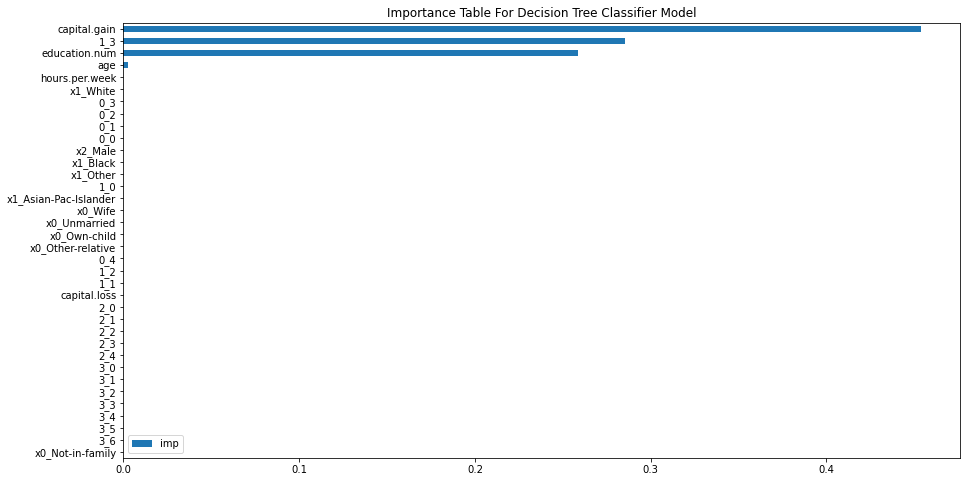

In [31]:
imptab_tree.sort_values('imp').plot(kind = 'barh', figsize = (15,8))
plt.title('Importance Table For Decision Tree Classifier Model')
plt.show()

**Ada Boost Classifier**

In [32]:
imptab_ada = pd.DataFrame(pipe_ada[1].feature_importances_, columns = ['imp'], index = features)

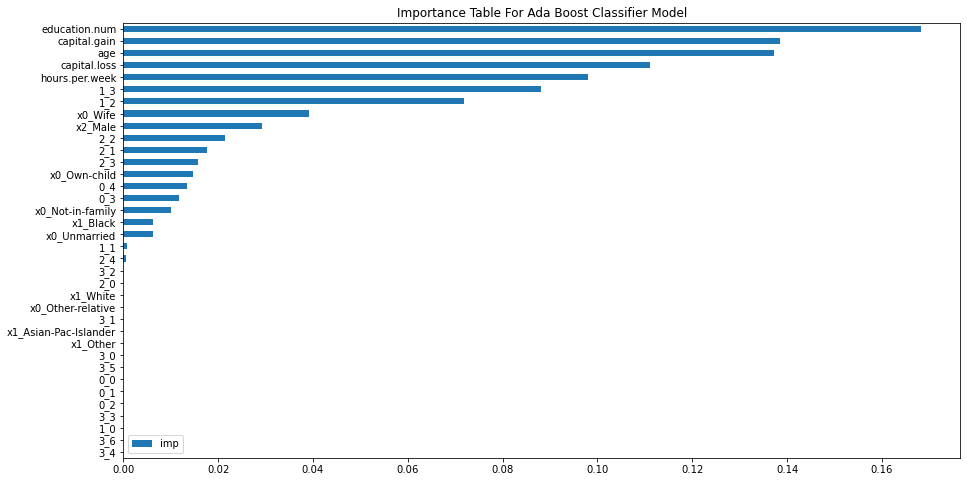

In [33]:
imptab_ada.sort_values('imp').plot(kind = 'barh', figsize = (15,8))
plt.title('Importance Table For Ada Boost Classifier Model')
plt.show()

**Gradient Boost Classifier**

In [34]:
imptab_grad = pd.DataFrame(pipe_grad[1].feature_importances_, columns = ['imp'], index = features)

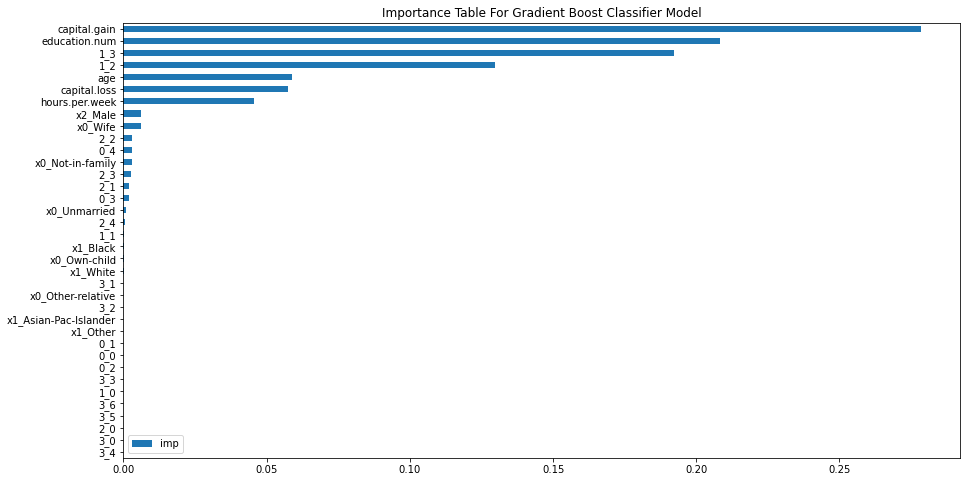

In [35]:
imptab_grad.sort_values('imp').plot(kind = 'barh', figsize = (15,8))
plt.title('Importance Table For Gradient Boost Classifier Model')
plt.show()

**XGB Classifier**

In [36]:
imptab_XGB = pd.DataFrame(pipe_XGB[1].feature_importances_, columns = ['imp'], index = features)

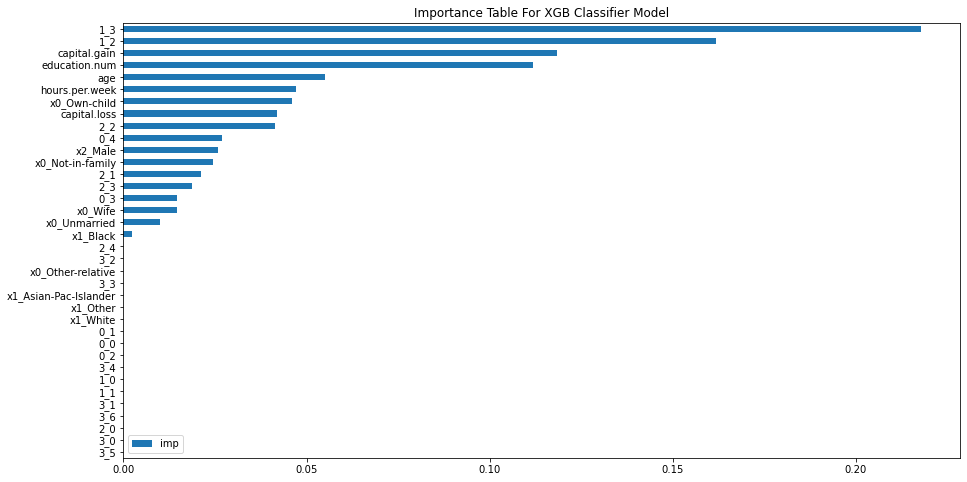

In [37]:
imptab_XGB.sort_values('imp').plot(kind = 'barh', figsize = (15,8))
plt.title('Importance Table For XGB Classifier Model')
plt.show()

# HyperParam Tuning

In [38]:
dt = DecisionTreeClassifier(max_depth = 3)
adaboost = AdaBoostClassifier(
            dt,
            n_estimators = 50,
            learning_rate = 0.1,
            random_state = 1212)

estimator = Pipeline([
    ('transformer', transformer),
    ('adaboost', adaboost)
])

In [39]:
hyperparam_space = {
    'adaboost__learning_rate': [0.1, 0.05, 0.01, 0.005],
    'adaboost__n_estimators': [50, 100, 150, 200, 400],
    'adaboost__base_estimator__max_depth': [3, 4, 5],
}

In [40]:
random = RandomizedSearchCV(
                estimator,
                param_distributions = hyperparam_space,
                cv = StratifiedKFold(n_splits = 5),
                scoring = 'f1',
                n_iter = 10,
                n_jobs = -1)

In [41]:
random.fit(X_train, y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('one '
                                                                               'hot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['relationship',
                                                                                'race',
                                                                                'sex']),
                                                                              ('binary',
                                                                               Pipeline(steps=[('imputer',
                

In [42]:
print('best score', random.best_score_)
print('best param', random.best_params_)

best score 0.7067564405670124
best param {'adaboost__n_estimators': 200, 'adaboost__learning_rate': 0.1, 'adaboost__base_estimator__max_depth': 4}


# Before VS After Tuning

In [43]:
estimator.fit(X_train, y_train)
y_pred_estimator = estimator.predict(X_test)
print(classification_report(y_test, y_pred_estimator))

              precision    recall  f1-score   support

           0       0.87      0.96      0.91      6181
           1       0.80      0.57      0.67      1960

    accuracy                           0.86      8141
   macro avg       0.84      0.76      0.79      8141
weighted avg       0.86      0.86      0.85      8141



In [44]:
random.best_estimator_.fit(X_train, y_train)
y_pred_random = random.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred_random))

              precision    recall  f1-score   support

           0       0.90      0.94      0.92      6181
           1       0.78      0.67      0.72      1960

    accuracy                           0.87      8141
   macro avg       0.84      0.80      0.82      8141
weighted avg       0.87      0.87      0.87      8141



In [45]:
f1_estimator = f1_score(y_test, y_pred_estimator)
f1_best_estimator = f1_score(y_test, y_pred_random)

In [46]:
score_list = [f1_estimator, f1_best_estimator]
method_name = ['Ada Boost Classifier Before Tuning', 'Ada Boost Classifier After Tuning']
best_summary = pd.DataFrame({
    'method': method_name,
    'score': score_list
})
best_summary

,method,score
0,Ada Boost Classifier Before Tuning,0.665272
1,Ada Boost Classifier After Tuning,0.716090


In [ ]:
Best estimator score: 0.716090, best n_estimators: 200, 